<a href="https://colab.research.google.com/github/kimbob123/LendingClub_ML/blob/main/LC_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###전처리

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from skopt import BayesSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/EDA/pure_budo.csv')
data.drop(['loan_status', 'ym', 'DATE_x', 'grade', 'sub_grade', 'Unnamed: 0','DATE_y', 'fico_range_low', 'emp_length' ], axis=1, inplace=True)

selected_variables = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_high',
    'mths_since_last_delinq', 'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths',
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_il_tl',
    'num_rev_accts', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit', 'GS2', 'UNRATE', 'term', 'collections_12_mths_ex_med',
    'chargeoff_within_12_mths', 'tax_liens' ,'id','defaulter'
]


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/raw_raw/lending_club_2020_train.csv')
raw_data['defaulter'] = raw_data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else (1 if x != 'Current' else None))
raw_data.dropna(subset=['defaulter'], inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136607 entries, 0 to 1755293
Columns: 142 entries, id to defaulter
dtypes: float64(107), object(35)
memory usage: 1.2+ GB


###파이프라인

### 모델 결과 출력

In [ ]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

data_real_number_columns = data.select_dtypes(include = ['float']).columns
data_real_number = data[data_real_number_columns]

#스케일링
scaler = MinMaxScaler()
data_real_number_normalized = scaler.fit_transform(data_real_number)
data_real_number_normalized_df = pd.DataFrame(data_real_number_normalized, columns=data_real_number_columns)

categorical_columns = data.select_dtypes(include=['object']).columns # 범주형 변수만을 선택
one_hot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
dummy_variables = one_hot_encoder.fit_transform(data[categorical_columns]) # 범주형 변수를 더미 변수로 변환
dummy_df = pd.DataFrame(dummy_variables.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns)) # 더미 변수를 데이터프레임으로 변환


# 실수형 자료 + 더미변수 // (원래의 데이터프레임에서 범주형 변수를 제거하고 더미 변수 데이터프레임을 추가)
data_final = pd.concat([data_real_number_normalized_df, dummy_df], axis=1)

a = data['id']
data_final['id'] = a
add_column = data['defaulter']
data_final['defaulter'] = add_column

# 데이터 준비
x = data_final.drop('defaulter', axis=1)
y = data_final['defaulter']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def pipeline(model, x, y, cut_off_values=None):
    # 리스트 초기화
    oversampling_accuracy_lst = []
    oversampling_precision_lst = []
    oversampling_recall_lst = []
    oversampling_f1_lst = []
    oversampling_auc_lst = []
    oversampling_auprc_lst = []  # AUPRC를 저장할 리스트
    best_params_list = []  # 최적의 파라미터를 저장할 리스트
    results = []

    if cut_off_values is None:
        cut_off_values = np.arange(0.2, 0.5, 0.1)  # 기본값: 0.1부터 0.9까지 0.1씩 증가

    stk = StratifiedKFold(n_splits=2, random_state=None, shuffle=True)

    for cut_off in cut_off_values:
        for train_index, test_index in stk.split(x, y):
            print("Train:", train_index, "Test:", test_index)
            original_Xtrain_id, original_Xtest_id = x.iloc[train_index], x.iloc[test_index]
            original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
            original_Xtrain = original_Xtrain_id.drop('id', axis=1)
            original_Xtest = original_Xtest_id.drop('id', axis=1)

            if model == 'logi':
                clf = LogisticRegression(random_state=42)
                param_space = {
                    'C': (0.001, 1000.0, 'log-uniform'),
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                }
            elif model == 'ranfo':
                clf = RandomForestClassifier(random_state=42)
                param_space = {  # 랜덤 포레스트용 파라미터 공간 정의
                    'n_estimators': (100, 1000),
                    'max_depth': (1, 20),
                    'min_samples_split': (2, 10),
                    'min_samples_leaf': (1, 10),
                    'max_features': (0.1, 1.0, 'uniform'),
                }
            elif model == 'xgb':
                clf = XGBClassifier()
                param_space = {  # XGBoost용 파라미터 공간 정의
                    'learning_rate': (0.001, 0.1, 'log-uniform'),
                    #'max_depth': (0, 20),
                    #'min_child_weight': (1, 10),
                    #'subsample': (0.5, 1.0, 'uniform'),
                    #'colsample_bytree': (0.5, 1.0, 'uniform'),
                    #'gamma': (0, 1)
                }

            # Bayesian Optimization을 위한 하이퍼파라미터 공간 정의

            # BayesSearchCV를 사용하여 베이지안 최적화 수행
            bayes_mod = BayesSearchCV(
                clf,
                param_space,
                n_iter=15,
                cv=stk,
                scoring='f1',
                random_state=42
            )

            # 베이지안 최적화 모델을 학습
            bayes_mod.fit(original_Xtrain, original_ytrain)

            # 최적의 추정기 및 하이퍼파라미터 찾기
            best_est = bayes_mod.best_estimator_

            # 베스트 파라미터 기록
            best_params_list.append(bayes_mod.best_params_)

            # 테스트 데이터에 대한 예측
            # prediction = best_est.predict(original_Xtest)
            probability = best_est.predict_proba(original_Xtest)[:, 1]

            cutoff = cut_off  # 컷오프를 원하는 값으로 설정
            prediction = (probability >= cutoff).astype(int)

            # 모델 평가 및 지표 계산
            oversampling_accuracy_lst.append(accuracy_score(original_ytest, prediction))
            oversampling_precision_lst.append(precision_score(original_ytest, prediction))
            oversampling_recall_lst.append(recall_score(original_ytest, prediction))
            oversampling_f1_lst.append(f1_score(original_ytest, prediction))
            oversampling_auc_lst.append(roc_auc_score(original_ytest, prediction))

            # Precision-Recall 곡선을 사용하여 AUPRC 계산
            precision, recall, _ = precision_recall_curve(original_ytest, prediction)
            auprc = auc(recall, precision)
            oversampling_auprc_lst.append(auprc)  # AUPRC를 리스트에 추가

            # 오차 행렬 출력
            confusion = confusion_matrix(original_ytest, prediction)
            print("Confusion Matrix:\n", confusion_matrix(original_ytest, prediction))
            print('대출된 건수:', confusion[0][0] + confusion[1][0])

            # F1 점수, 재현율, 정밀도, 정확도 및 AUPRC 출력
            f1 = f1_score(original_ytest, prediction)
            recall = recall_score(original_ytest, prediction)
            precision = precision_score(original_ytest, prediction)
            accuracy = accuracy_score(original_ytest, prediction)
            auprc = average_precision_score(original_ytest, probability)

            # 예측 결과를 데이터프레임으로 만들기
            result = pd.DataFrame({'id': original_Xtest_id['id'],
                                   'defaulter_prediction': prediction,
                                   'defaulter_probability': probability})

            # 테스트 데이터와 예측 결과 병합
            merged_df = pd.merge(result, raw_data, on='id', how='inner')
            merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)


            all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                                (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]


            all_loan['last_pymnt_d'] = pd.to_datetime(all_loan['last_pymnt_d'], format='%b-%Y')
            all_loan['issue_d'] = pd.to_datetime(all_loan['issue_d'], format='%b-%Y')

            # issue_d와 last_pymnt_d의 차이 계산
            all_loan['paid_months'] = (all_loan['last_pymnt_d'] - all_loan['issue_d']) / pd.Timedelta(days=30)
            # 'paid_months' 열이 0인 행 필터링하여 해당 열 값을 1로 변경
            all_loan.loc[all_loan['paid_months'] == 0, 'paid_months'] = 1

            discount_rate = (all_loan['total_pymnt'] / all_loan['funded_amnt'] ) ** (12 / all_loan['paid_months']) -1



            # 할인율 분포 시각화
            plt.figure()
            plt.hist(discount_rate, bins=5000, color='blue', density=True, alpha=0.7)

            # 평균과 중앙값 계산
            mean_discount_rate = discount_rate.mean()
            median_discount_rate = discount_rate.median()

            # 평균선과 중앙값 표시
            plt.axvline(x=mean_discount_rate, color='red', linestyle='--', label='Mean')
            plt.axvline(x=median_discount_rate, color='orange', linestyle='--', label='Median')

            plt.xlabel('Discount Rate')
            plt.ylabel('Density')
            plt.title('Discount Rate Distribution')
            plt.xlim(-0.04, 0.2)
            plt.legend()
            plt.show()


            print('할인율 평균:', discount_rate.mean())
            print('할인율 중앙값:', discount_rate.median())
            print('할인율 표준편차:', discount_rate.std())
            print(' ')

            # 데이터프레임 생성
            result_df = pd.DataFrame({'Cut Off': [cutoff],
                                      'Accuracy': [accuracy_score(original_ytest, prediction)],
                                      'Precision': [precision_score(original_ytest, prediction)],
                                      'Recall': [recall_score(original_ytest, prediction)],
                                      'F1 Score': [f1_score(original_ytest, prediction)],
                                      'AUPRC': [auprc],
                                      'mean_rate': [mean_discount_rate],
                                      'median': [median_discount_rate],
                                      'std': [discount_rate.std()],
                                      'Model': [model],
                                      'para': [best_est],
                                      'Size': [confusion[0][0] + confusion[1][0]]})

            results.append(result_df)


          # 결과 출력
        print("Mean Accuracy:", np.mean(oversampling_accuracy_lst))
        print("Mean Precision:", np.mean(oversampling_precision_lst))
        print("Mean Recall:", np.mean(oversampling_recall_lst))
        print("Mean F1 Score:", np.mean(oversampling_f1_lst))
        print("Mean AUC:", np.mean(oversampling_auc_lst))
        print("Mean AUPRC:", np.mean(oversampling_auprc_lst))
        print("BestParameters:", best_params_list)
        print('\n')

    return results

Train: [      1       5       7 ... 1078515 1078519 1078520] Test: [      0       2       3 ... 1078518 1078521 1078522]
Confusion Matrix:
 [[285808 147517]
 [ 34979  70958]]
대출된 건수: 320787


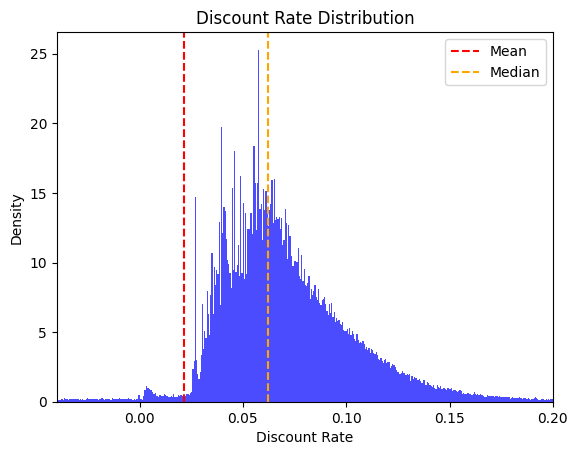

할인율 평균: 0.0213898241227819
할인율 중앙값: 0.06235637921957671
할인율 표준편차: 0.18975773275069754
 
Train: [      0       2       3 ... 1078518 1078521 1078522] Test: [      1       5       7 ... 1078515 1078519 1078520]
Confusion Matrix:
 [[285902 147422]
 [ 35070  70867]]
대출된 건수: 320972


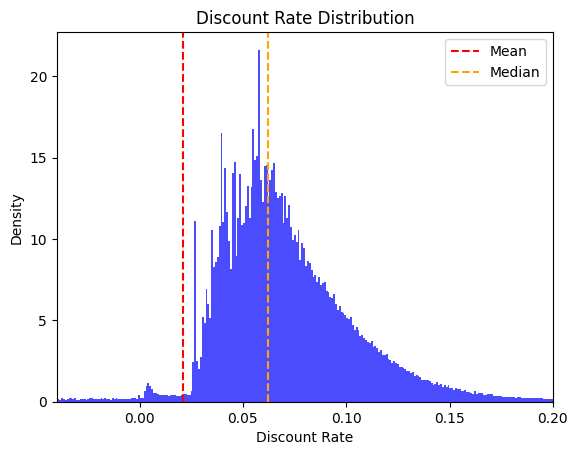

할인율 평균: 0.02080459260225097
할인율 중앙값: 0.062070691415237356
할인율 표준편차: 0.19038643170463934
 
Mean Accuracy: 0.6615853347618873
Mean Precision: 0.3247176666749906
Mean Recall: 0.6693836903065029
Mean F1 Score: 0.4373008845221641
Mean AUC: 0.6645312611735924
Mean AUPRC: 0.529525183014264
BestParameters: [OrderedDict([('learning_rate', 0.09996633505580733)]), OrderedDict([('learning_rate', 0.1)])]


Train: [      0       2       4 ... 1078517 1078520 1078521] Test: [      1       3       6 ... 1078518 1078519 1078522]
Confusion Matrix:
 [[370480  62845]
 [ 62823  43114]]
대출된 건수: 433303


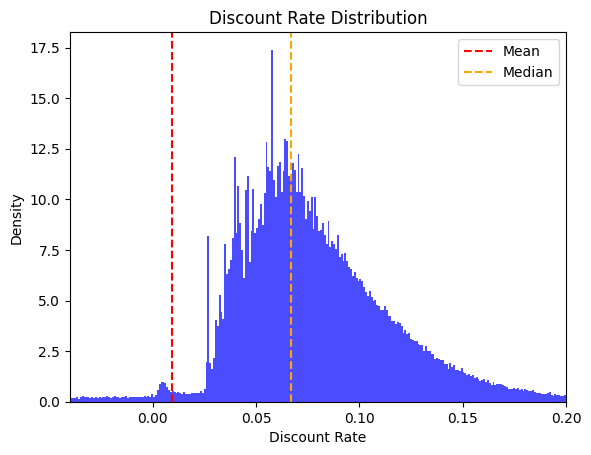

할인율 평균: 0.009551232805882236
할인율 중앙값: 0.06698587946300605
할인율 표준편차: 0.22244843747313228
 
Train: [      1       3       6 ... 1078518 1078519 1078522] Test: [      0       2       4 ... 1078517 1078520 1078521]
Confusion Matrix:
 [[370718  62606]
 [ 62502  43435]]
대출된 건수: 433220


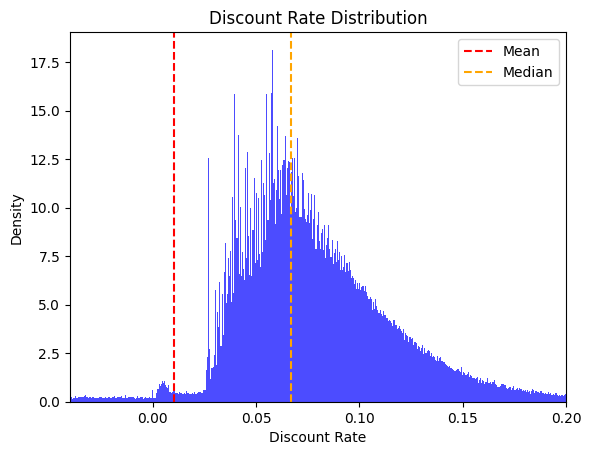

할인율 평균: 0.010332819228854368
할인율 중앙값: 0.06708357422702793
할인율 표준편차: 0.22187579562312998
 
Mean Accuracy: 0.7145336726812539
Mean Precision: 0.36648357104519236
Mean Recall: 0.5389382368766342
Mean F1 Score: 0.42283598121934435
Mean AUC: 0.6482003003772661
Mean AUPRC: 0.4979983015840779
BestParameters: [OrderedDict([('learning_rate', 0.09996633505580733)]), OrderedDict([('learning_rate', 0.1)]), OrderedDict([('learning_rate', 0.09996633505580733)]), OrderedDict([('learning_rate', 0.09996335647503692)])]


Train: [      1       3       4 ... 1078514 1078515 1078522] Test: [      0       2       9 ... 1078519 1078520 1078521]
Confusion Matrix:
 [[410534  22791]
 [ 83443  22494]]
대출된 건수: 493977


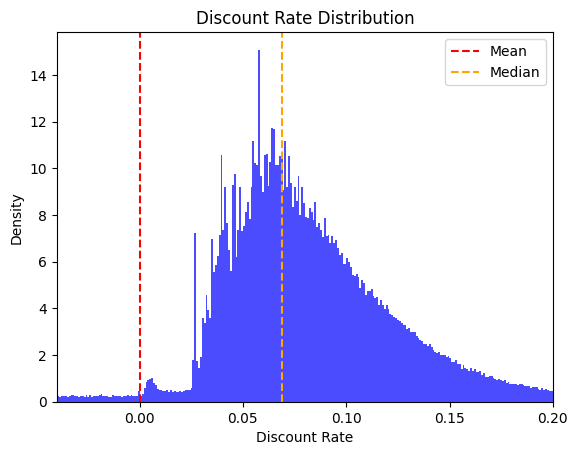

할인율 평균: 0.00014477838977233399
할인율 중앙값: 0.0687154636733589
할인율 표준편차: 0.2437961102743842
 
Train: [      0       2       9 ... 1078519 1078520 1078521] Test: [      1       3       4 ... 1078514 1078515 1078522]
Confusion Matrix:
 [[410143  23181]
 [ 83545  22392]]
대출된 건수: 493688


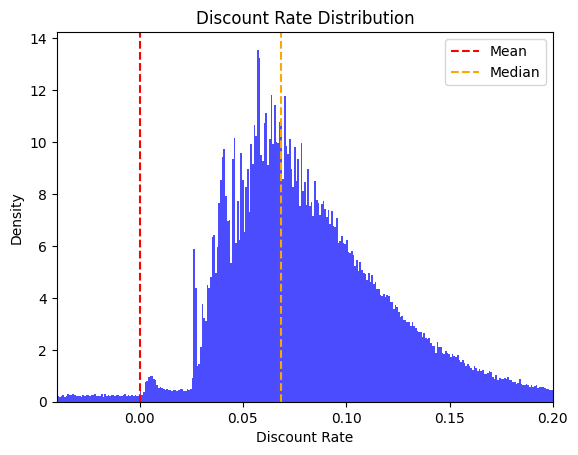

할인율 평균: 8.647299580826928e-05
할인율 중앙값: 0.06865825717265928
할인율 표준편차: 0.24363058926765943
 
Mean Accuracy: 0.7438707071510592
Mean Precision: 0.40899976855553555
Mean Recall: 0.42990960035996234
Mean F1 Score: 0.3807374617959511
Mean AUC: 0.6252679719359366
Mean AUPRC: 0.4754513267611013
BestParameters: [OrderedDict([('learning_rate', 0.09996633505580733)]), OrderedDict([('learning_rate', 0.1)]), OrderedDict([('learning_rate', 0.09996633505580733)]), OrderedDict([('learning_rate', 0.09996335647503692)]), OrderedDict([('learning_rate', 0.09996335647503692)]), OrderedDict([('learning_rate', 0.1)])]




In [ ]:
list = pipeline('xgb',x,y)

In [ ]:
list[0]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.2,0.661582,0.324788,0.669813,0.437456,0.394875,0.02139,0.062356,0.189758,xgb,"XGBClassifier(base_score=None, booster=None, c...",320787


In [ ]:
list[1]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.2,0.661589,0.324648,0.668954,0.437146,0.39534,0.020805,0.062071,0.190386,xgb,"XGBClassifier(base_score=None, booster=None, c...",320972


In [ ]:
list[2]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.3,0.766963,0.406893,0.406978,0.406935,0.394924,0.009551,0.066986,0.222448,xgb,"XGBClassifier(base_score=None, booster=None, c...",433303


In [ ]:
list[3]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.3,0.768001,0.409606,0.410008,0.409807,0.395662,0.010333,0.067084,0.221876,xgb,"XGBClassifier(base_score=None, booster=None, c...",433220


In [ ]:
list[4]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.4,0.803001,0.496721,0.212334,0.297496,0.398008,0.000145,0.068715,0.243796,xgb,"XGBClassifier(base_score=None, booster=None, c...",493977


In [ ]:
list[5]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,mean_rate,median,std,Model,para,Size
0,0.4,0.802088,0.491344,0.211371,0.295584,0.393115,0.000086,0.068658,0.243631,xgb,"XGBClassifier(base_score=None, booster=None, c...",493688
